## 🛠️ Mod5 Data Challenge 5: Cohorts & Retention 


**Why this activity?**  
You’ll build **cohort retention** from real transaction data to answer: *Are customers coming back after their first purchase?* This extends today’s lecture on Cohorts & Retention to a real dataset.

**Dataset:** UCI Online Retail II.  View more [HERE](https://archive.ics.uci.edu/dataset/502/online+retail+ii) 

**Goals — You will be able to:**
1) Load & clean real transaction data (remove cancellations, keep positive quantities/prices).  
2) Build **time‑anchored cohorts** (first purchase period).  
3) Compute a **cohort retention matrix** (monthly or weekly).  
4) Explain differences and propose product/marketing actions.

**Interview practice:**
- **Q1:** Why can MAU look stable while retention collapses?  
- **Q2:** Day/Month‑1 retention fell for the newest cohort—what do you check first?  
- **Q3:** When would you choose weekly vs monthly cohorts?


### 👩‍🏫 Instructor-Led Demo (25 minutes)

### Step 1:  Load & clean the Online Retail II Excel

We will:  
1) Read **both sheets** from the Excel file and concatenate.  
2) Parse dates.  
3) Drop rows with missing CustomerID and standardize types.  
4) Create an **activity date** column (we’ll use InvoiceDate).

Note:  We are keeping returns and cancellations in the data (for now) this may affect KPIs (like revenue), which is outside the scope of this cohort exercise but VERY important to point out.  


In [1]:
# import packages per usual 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Path to your downloaded Excel file
DATA_PATH = '/Users/ayemaq/Desktop/marcy_lab/DA2025_Lectures/Mod5/DataChallenges/data/online_retail_II.xlsx'

# 1) Read both sheets and concatenate
sheets = ["Year 2009-2010", "Year 2010-2011"]
df_list = [pd.read_excel(DATA_PATH, sheet_name=s, engine="openpyxl") for s in sheets]
df = pd.concat(df_list, ignore_index=True)

# 2) Change InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# 4) Drop missing CustomerID and standardize types
df = df.dropna(subset=["Customer ID"]).copy()
df["Customer ID"] = df['Customer ID'].astype(int).astype(str)

# 5) Activity date (alias for clarity)
df["activity_date"] = df["InvoiceDate"]

df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,activity_date
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,2009-12-01 07:45:00
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,2009-12-01 07:45:00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,2009-12-01 07:45:00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,2009-12-01 07:45:00
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,2009-12-01 07:45:00


#### Step 2:  Filter for a country (UK) and define cohorts 

We will:  
1) Keep rows where `Country == "United Kingdom"`.  
2) Define **cohort_month** as each customer’s first activity month.  
3) Define **activity_month** for each row.  
4) Compute **month_number** = months since cohort start.

**Speaker Notes:** Cohorts are anchored by **first activity**; “Month 0” is the signup month; “Month 1” is the following month, etc.


In [4]:
# 1) Country filter
df_uk = df[df['Country'] == 'United Kingdom'].copy()

# 2) First activity month (cohort anchor) per customer
df_uk["cohort_month"] = df_uk.groupby('Customer ID')['activity_date'].transform('min').dt.to_period('M')

# 3) Activity month per row
df_uk["activity_month"] = df_uk["activity_date"].dt.to_period('M')

# 4) Months since cohort start
df_uk["month_number"] = (df_uk["activity_month"] - df_uk["cohort_month"]).apply(lambda x: x.n)

df_uk[["Customer ID","activity_date","cohort_month","activity_month","month_number"]].head()



,Customer ID,activity_date,cohort_month,activity_month,month_number
0,13085,2009-12-01 07:45:00,2009-12,2009-12,0
1,13085,2009-12-01 07:45:00,2009-12,2009-12,0
2,13085,2009-12-01 07:45:00,2009-12,2009-12,0
3,13085,2009-12-01 07:45:00,2009-12,2009-12,0
4,13085,2009-12-01 07:45:00,2009-12,2009-12,0


**Think:  Why do we see duplicate customer ID's here with the same activity date**?

#### Step 3:  Build a monthly retention matrix and normalize by cohort size

We will:  
1) Count **unique active customers** by (`cohort_month`, `month_number`).  
2) Pivot to cohorts × months.  
3) Divide each row by **Month 0** to get retention fractions.

**Speaker Notes:** Using unique customers avoids overcounting heavy purchasers; we measure presence, not volume.


In [12]:
# 1) Unique active customers per (cohort_month, month_number)
cohort_counts_m = df_uk.groupby(["cohort_month","month_number"])["Customer ID"].nunique().reset_index()

# 2) Pivot
retention_m = cohort_counts_m.pivot_table(index='cohort_month', columns='month_number', values='Customer ID')

# 3) Normalize by cohort size (Month 0)
cohort_size_m = retention_m.iloc[:, 0]
retention_m_frac = retention_m.div(cohort_size_m, axis=0)

retention_m_frac

month_number,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
cohort_month,,,,,,,,,,,,,,,,,,,,,
2009-12,1.0,0.373225,0.338742,0.423935,0.392495,0.391481,0.385396,0.354970,0.339757,0.368154,...,0.295132,0.258621,0.300203,0.279919,0.267748,0.255578,0.311359,0.298174,0.400609,0.203854
2010-01,1.0,0.230769,0.313390,0.316239,0.282051,0.310541,0.267806,0.239316,0.287749,0.333333,...,0.153846,0.222222,0.193732,0.173789,0.188034,0.247863,0.185185,0.225071,0.074074,NaN
2010-02,1.0,0.294294,0.222222,0.312312,0.255255,0.216216,0.210210,0.279279,0.279279,0.285285,...,0.195195,0.177177,0.174174,0.138138,0.234234,0.246246,0.153153,0.063063,NaN,NaN
2010-03,1.0,0.218673,0.267813,0.240786,0.235872,0.206388,0.245700,0.302211,0.297297,0.115479,...,0.169533,0.181818,0.157248,0.169533,0.206388,0.213759,0.081081,NaN,NaN,NaN
2010-04,1.0,0.226415,0.203774,0.162264,0.188679,0.222642,0.271698,0.256604,0.109434,0.098113,...,0.147170,0.135849,0.150943,0.162264,0.207547,0.067925,NaN,NaN,NaN,NaN
2010-05,1.0,0.188034,0.175214,0.200855,0.192308,0.256410,0.226496,0.132479,0.059829,0.068376,...,0.115385,0.136752,0.170940,0.145299,0.051282,NaN,NaN,NaN,NaN,NaN
2010-06,1.0,0.201613,0.201613,0.209677,0.229839,0.286290,0.137097,0.080645,0.080645,0.120968,...,0.104839,0.129032,0.205645,0.060484,NaN,NaN,NaN,NaN,NaN,NaN
2010-07,1.0,0.204969,0.186335,0.291925,0.285714,0.149068,0.093168,0.136646,0.118012,0.118012,...,0.173913,0.242236,0.086957,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,1.0,0.234483,0.317241,0.303448,0.172414,0.137931,0.082759,0.137931,0.137931,0.137931,...,0.193103,0.062069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Step 4:  Heatmap & Interpretation

We will:  
1) Plot a seaborn heatmap of the **monthly** retention (0–1).  
2) Write 2–3 sentences on what improves/worsens by Month 1 & Month 2 for UK, and 1 action you’d take.

**Speaker Notes:** Visuals make cohort stories click; ask “what happened around low‑retention cohorts?”


In [ ]:
# Plot heatmap of monthly retention (0–1)
mat_m = retention_m_frac.copy().astype(float).sort_index(axis=0).sort_index(axis=1)
plt.figure(figsize=(10, 5))
ax = sns.heatmap(mat_m, annot=True, fmt=".0%", cbar_kws={"label": "Retention (0–1)"}, vmin=0, vmax=1)
ax.set_title("United Kingdom — Monthly Cohort Retention")
ax.set_xlabel("Months Since First Purchase")
ax.set_ylabel("Cohort (Signup Month)")
plt.tight_layout()
plt.show()

### 👩‍💻 Student-Led Section (20 minutes) -- ANSWER KEY

### Step 1: Filter to Germany (DE) and define weekly cohorts

  
1) Keep rows where `Country == "Germany"`.  
2) Define **cohort_week** as each customer’s first activity week.  
3) Define **activity_week** for each row.  
4) Compute **week_number** = weeks since cohort start.





In [8]:
# 1) Country filter
df_de = df[df["Country"] == "Germany"].copy()

# 2) First activity week (cohort anchor) per customer do your groupby
df_de["cohort_week"] = df_de.groupby("Customer ID")["activity_date"].transform("min").dt.to_period("W")

# 3) Activity week per row
df_de["activity_week"] = df_de["activity_date"].dt.to_period("W")

# 4) Weeks since cohort start (subtract cohort week from activity week)
df_de["week_number"] = (df_de["activity_week"] - df_de["cohort_week"]).apply(lambda x: x.n)

df_de[["Customer ID","activity_date","cohort_week","activity_week","week_number"]].head()

,Customer ID,activity_date,cohort_week,activity_week,week_number
579,12533,2009-12-01 11:50:00,2009-11-30/2009-12-06,2009-11-30/2009-12-06,0
580,12533,2009-12-01 11:50:00,2009-11-30/2009-12-06,2009-11-30/2009-12-06,0
581,12533,2009-12-01 11:50:00,2009-11-30/2009-12-06,2009-11-30/2009-12-06,0
582,12533,2009-12-01 11:50:00,2009-11-30/2009-12-06,2009-11-30/2009-12-06,0
583,12533,2009-12-01 11:50:00,2009-11-30/2009-12-06,2009-11-30/2009-12-06,0


#### Step 2:  Build a **weekly** retention matrix and normalize by cohort size
  
1) Count **unique active customers** by (`cohort_week`, `week_number`).  
2) Pivot to cohorts × weeks.  
3) Divide each row by **Week 0** to get retention fractions.


In [10]:
# 1) Unique active customers per (cohort_week, week_number)
cohort_counts_w = df_de.groupby(["cohort_week", "week_number"])["Customer ID"].nunique().reset_index()

# 2) Pivot
retention_w = cohort_counts_w.pivot(index="cohort_week", columns="week_number", values="Customer ID")

# 3) Normalize by cohort size (Week 0)
cohort_size_w = retention_w.iloc[:, 0]
retention_w_frac = retention_w.div(cohort_size_w, axis=0)

retention_w_frac

week_number,0,1,2,3,4,5,6,7,8,9,...,96,97,98,99,100,101,102,103,104,105
cohort_week,,,,,,,,,,,,,,,,,,,,,
2009-11-30/2009-12-06,1.0,0.500000,0.250000,0.250000,NaN,0.250000,0.500000,NaN,0.250000,0.250000,...,0.500000,0.25,NaN,0.500000,0.50,0.25,0.25,0.5,0.25,0.25
2009-12-07/2009-12-13,1.0,0.500000,0.250000,NaN,0.250000,0.750000,NaN,0.5,0.250000,0.500000,...,0.250000,0.50,0.25,NaN,0.75,0.25,0.25,NaN,0.25,NaN
2009-12-14/2009-12-20,1.0,NaN,NaN,NaN,0.333333,0.333333,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04/2010-01-10,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11/2010-01-17,1.0,0.250000,0.500000,0.500000,0.500000,NaN,0.250000,0.5,NaN,0.250000,...,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-18/2010-01-24,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.333333,NaN,...,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-25/2010-01-31,1.0,NaN,NaN,NaN,NaN,1.000000,0.500000,NaN,NaN,NaN,...,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-01/2010-02-07,1.0,NaN,NaN,0.500000,NaN,0.500000,0.500000,NaN,NaN,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-08/2010-02-14,1.0,0.285714,NaN,0.285714,0.142857,0.142857,0.285714,NaN,NaN,0.142857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Step 3:  Weekly heatmap & interpretation (Can be hard to see all weeks together -- try filtering OR Tableau on your own later)

1) Plot a seaborn heatmap of weekly retention (0–1).  
2) Write 2–3 sentences interpreting where Germany shows stronger/weaker weekly retention and one hypothesis for *why*.
- Germany shows stronger weekly retention in earlier cohorts (around 2009–2010), where retention stays higher for more weeks after the first purchase. On the other hand, newer cohorts (2011 onward) shows weaker retention, users were dropping off more quickly. A possible hypothesis can be that earlier users had stronger customer engagment or loyalty while users later on may have faced more frictions or product changes that affected the experience users negatively
 

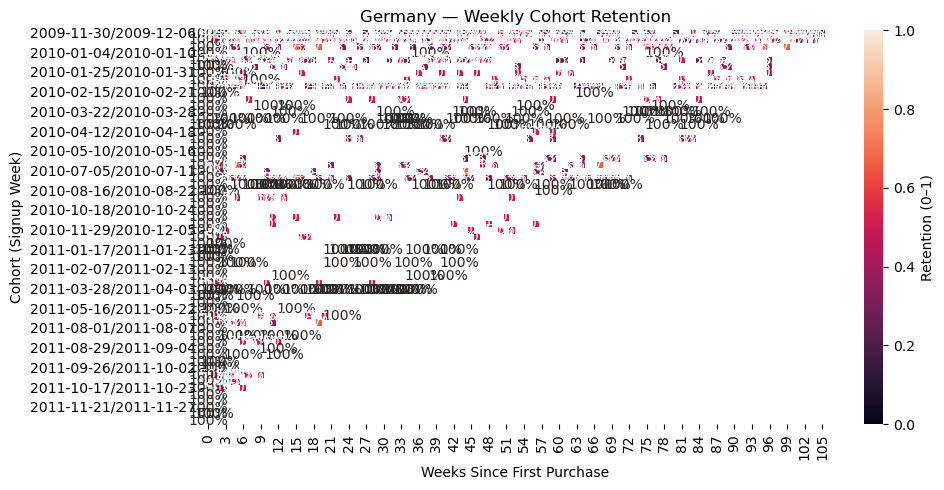

In [11]:
# Plot heatmap of weekly retention (0–1)
mat_w = retention_w_frac.copy().astype(float).sort_index(axis=0).sort_index(axis=1)
plt.figure(figsize=(10, 5))
ax = sns.heatmap(mat_w, annot=True, fmt=".0%", cbar_kws={"label": "Retention (0–1)"}, vmin=0, vmax=1)
ax.set_title("Germany — Weekly Cohort Retention")
ax.set_xlabel("Weeks Since First Purchase")
ax.set_ylabel("Cohort (Signup Week)")
plt.tight_layout()
plt.show()

### Wrap‑Up: Reading & Acting on Cohorts -- (15 mins)

**Students:  Be prepared to reflect and answer the interview questions at the top of this notebook.**  

- **Time matters:** Cohorts track the *same users* over time; MAU can hide churn if new users replace old ones.
- **Granularity choice:** Weekly cohorts reveal short‑term dynamics (promos, bugs); monthly cohorts smooth noise but may hide spikes.
- **Market differences:** UK monthly vs Germany weekly shows how market and period choice change the narrative.
- **Actions:** If Month/Week‑1 retention dips, audit onboarding, returns/shipping policy, payment UX, or marketing sources in that signup window.
- **Next:** Segment cohorts by acquisition channel or product category to find who sticks and why. Tie changes to a single success metric (e.g., +5pp in Month‑1 retention for new cohorts).
